In [1]:
import pandas as pd
import numpy as np
import networkx as nx

In [2]:
df = pd.read_csv('Nazario.csv')
df.head()

,sender,receiver,date,subject,body,urls,label
0,Mail System Internal Data <MAILER-DAEMON@monke...,NaN,28 Sep 2017 09:57:25 -0400,DON'T DELETE THIS MESSAGE -- FOLDER INTERNAL DATA,This text is part of the internal format of yo...,1,1
1,cPanel <service@cpanel.com>,jose@monkey.org,"Fri, 30 Oct 2015 00:00:48 -0500",Verify Your Account,Business with \t\t\t\t\t\t\t\tcPanel & WHM \t...,1,1
2,Microsoft Outlook <recepcao@unimedceara.com.br>,NaN,"Fri, 30 Oct 2015 06:21:59 -0300 (BRT)",Helpdesk Mailbox Alert!!!,Your two incoming mails were placed on pending...,1,1
3,Ann Garcia <AnGarcia@mcoe.org>,"""info@maaaaa.org"" <info@maaaaa.org>","Fri, 30 Oct 2015 14:54:33 +0000",IT-Service Help Desk,Password will expire in 3 days. Click Here To ...,0,1
4,"""USAA"" <usaaacctupdate@sccu4u.com>",Recipients <usaaacctupdate@sccu4u.com>,"Fri, 30 Oct 2015 14:02:33 -0500",Final USAA Reminder - Update Your Account Now,"To ensure delivery to your inbox, please add U...",1,1


In [6]:
df.size

10955

/var/folders/c0/yhnphyvx1vnfs0tsn9r6xl_m0000gn/T/ipykernel_16409/2430461578.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/var/folders/c0/yhnphyvx1vnfs0tsn9r6xl_m0000gn/T/ipykernel_16409/2430461578.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


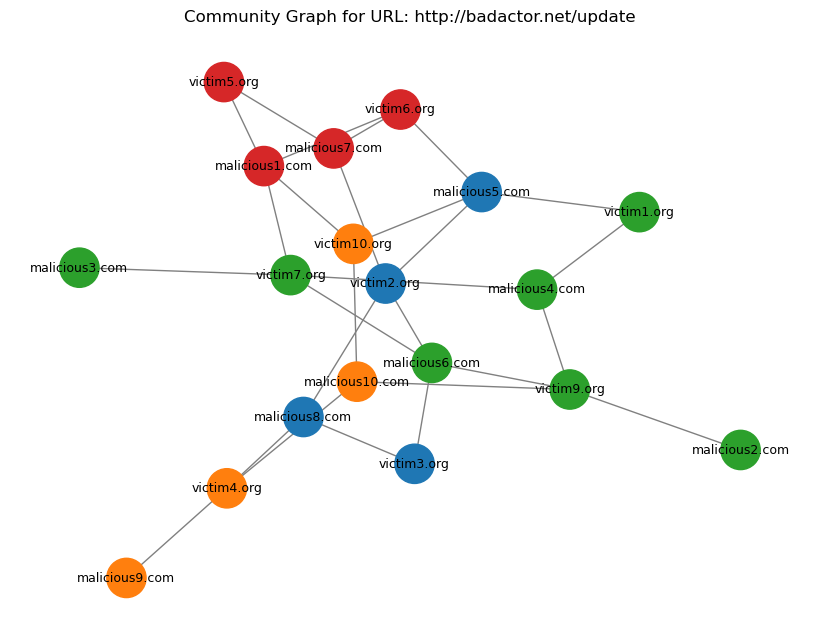

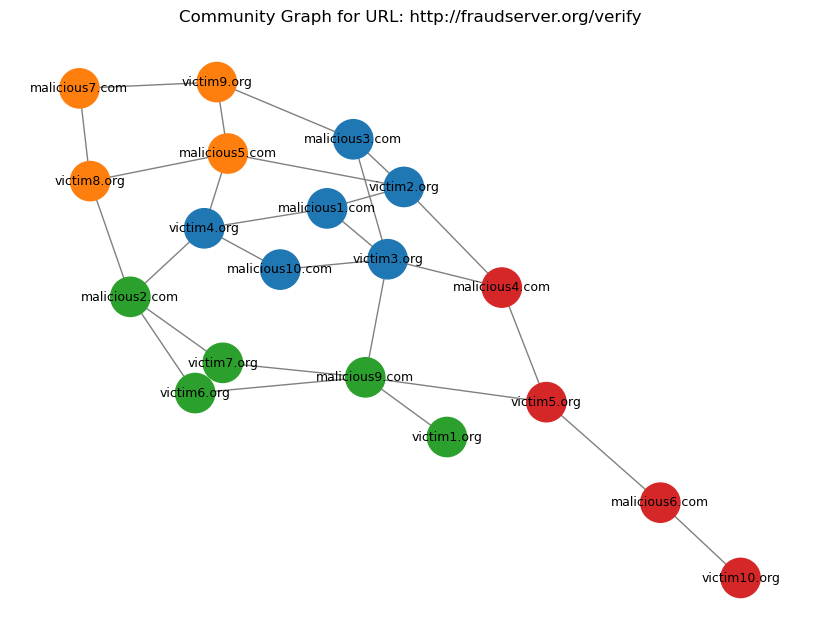

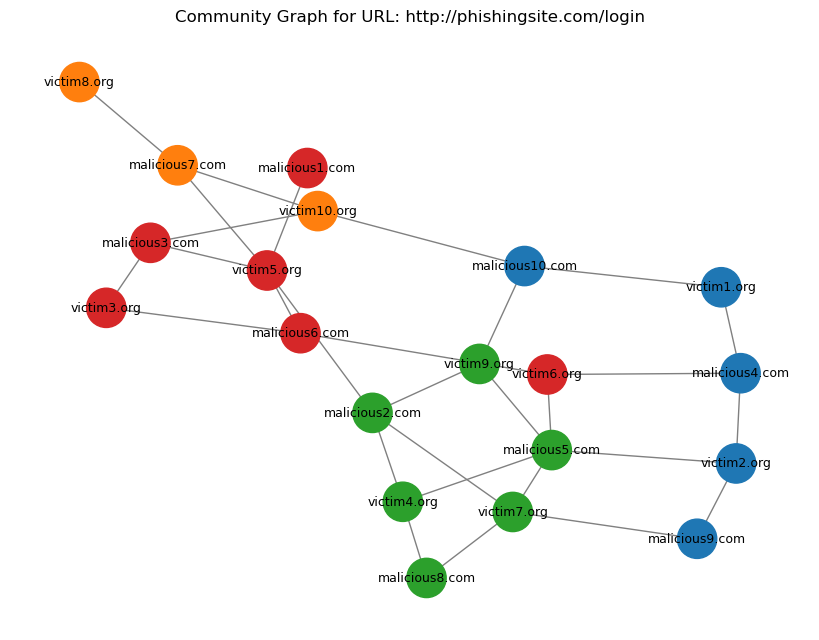


Community Detection per URL:
                              url           domain  community
0      http://badactor.net/update   malicious5.com          0
9      http://badactor.net/update      victim2.org          0
11     http://badactor.net/update   malicious8.com          0
12     http://badactor.net/update      victim3.org          0
1      http://badactor.net/update     victim10.org          1
5      http://badactor.net/update  malicious10.com          1
14     http://badactor.net/update      victim4.org          1
18     http://badactor.net/update   malicious9.com          1
2      http://badactor.net/update   malicious3.com          2
3      http://badactor.net/update      victim7.org          2
6      http://badactor.net/update   malicious4.com          2
7      http://badactor.net/update      victim9.org          2
13     http://badactor.net/update      victim1.org          2
15     http://badactor.net/update   malicious6.com          2
17     http://badactor.net/update   mali

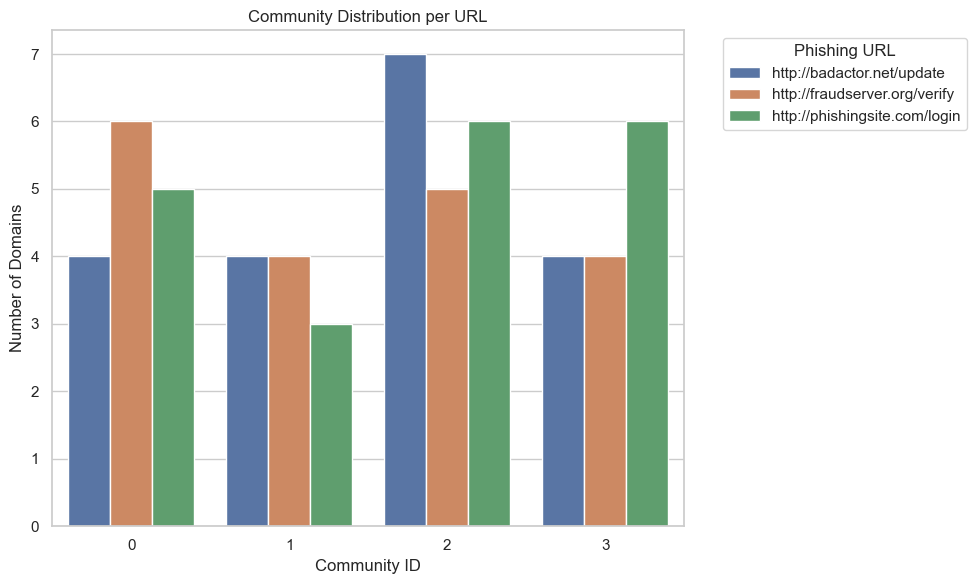

In [5]:
# 📘 Use Case: Detect Suspicious Sender Communities (Phishing Clusters)
# Community Detection per URL — sender/receiver as edge, domains as nodes

import pandas as pd
import re
import random
import numpy as np
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 0: Generate Dummy Data (instead of reading CSV) ---
random.seed(42)
np.random.seed(42)

sender_domains = [f"malicious{i}.com" for i in range(1, 11)]
receiver_domains = [f"victim{i}.org" for i in range(1, 11)]
phishing_urls = [
    "http://phishingsite.com/login",
    "http://badactor.net/update",
    "http://fraudserver.org/verify"
]

dummy_data = []
for _ in range(100):
    sender = f"user{random.randint(1,20)}@{random.choice(sender_domains)}"
    receiver = f"employee{random.randint(1,50)}@{random.choice(receiver_domains)}"
    url = random.choice(phishing_urls)
    dummy_data.append({
        "sender": sender,
        "receiver": receiver,
        "urls": url
    })

df = pd.DataFrame(dummy_data)

# --- Step 1: Extract Domains ---
def extract_domain(email):
    if pd.isna(email): return None
    clean = re.sub(r'.*<(.+?)>', r'\1', email).strip().lower()
    match = re.search(r'@([a-z0-9.\-]+)$', clean)
    return match.group(1) if match else None

df['sender_domain'] = df['sender'].apply(extract_domain)
df['receiver_domain'] = df['receiver'].apply(extract_domain)

# --- Step 2: Clean and Expand URLs ---
def split_urls(url_str):
    if pd.isna(url_str) or url_str.strip() == '':
        return []
    return [url.strip() for url in url_str.split(',') if url.strip()]

df['url_list'] = df['urls'].apply(split_urls)
df_exploded = df.explode('url_list').dropna(subset=['url_list'])

# --- Step 3: Perform Community Detection Per URL ---
all_results = []

for url, group in df_exploded.groupby('url_list'):
    G = nx.Graph()
    for row in group.itertuples():
        G.add_edge(row.sender_domain, row.receiver_domain)

    if G.number_of_nodes() == 0:
        continue

    partition = community_louvain.best_partition(G)

    for node, comm in partition.items():
        all_results.append({
            'url': url,
            'domain': node,
            'community': comm
        })

    # --- Step 4: Draw Network Graph per URL ---
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    cmap = plt.cm.get_cmap('tab10')
    colors = [cmap(partition[n] % cmap.N) for n in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_color=colors, edge_color='gray', node_size=800, font_size=9)
    plt.title(f"Community Graph for URL: {url}")
    plt.tight_layout()
    plt.show()

# --- Step 5: Create Summary DataFrame ---
result_df = pd.DataFrame(all_results)
print("\nCommunity Detection per URL:")
print(result_df.sort_values(by=['url', 'community']))

# --- Step 6: Bar Plot per URL ---
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=result_df, x='community', hue='url')
plt.title("Community Distribution per URL")
plt.xlabel("Community ID")
plt.ylabel("Number of Domains")
plt.legend(title="Phishing URL", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities

# === LOAD AND PREPROCESS DATA ===
df = pd.read_csv("your_email_data.csv")  # Replace with your file path
df = df.dropna(subset=["from_domain", "to_domain"])
df["from_domain"] = df["from_domain"].str.lower().str.strip()
df["to_domain"] = df["to_domain"].str.lower().str.strip()

# Normalize URL column
def explode_urls(row):
    if isinstance(row, str):
        return [u.strip() for u in row.split(",") if u.strip()]
    elif isinstance(row, list):
        return row
    return []
df["urls"] = df["urls"].apply(explode_urls)

# === BUILD GRAPH ===
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row["from_domain"], row["to_domain"])

# === ANALYZE ===
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
undirected_G = G.to_undirected()
communities = list(greedy_modularity_communities(undirected_G))
community_map = {node: i for i, c in enumerate(communities) for node in c}

# === DRAW ===
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Color nodes by sender (red) or receiver (blue)
node_colors = []
for node in G.nodes():
    if node in df["from_domain"].values:
        node_colors.append("red")
    else:
        node_colors.append("blue")

# Node size by degree
node_sizes = [300 + 100*(in_degrees.get(n,0)+out_degrees.get(n,0)) for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=10, edge_color='gray', alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Targeted Phishing: Domain-to-Domain Email Graph", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

# === INSIGHTS ===
print("🔺 Top Sending Domains:\n", pd.Series(out_degrees).sort_values(ascending=False).head(5))
print("🎯 Most Targeted Domains:\n", pd.Series(in_degrees).sort_values(ascending=False).head(5))
